In [1]:
import seaborn as sns
from collections import defaultdict

import seisbench.data as sbd
import seisbench.generate as sbg
import numpy as np
import matplotlib.pyplot as plt
from seisbench.util import worker_seeding
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import einops
import tqdm
from sklearn.manifold import TSNE

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from collections import defaultdict
from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2, MultiDimWav2Vec2ForPreTraining

/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LitMultiDimWav2Vec2.load_from_checkpoint(
  '/home/liu0003/Desktop/projects/seisLM/results/models/pretrained_seisLM/pretrain_config_layernorm_std_small_batch_6_datasets_42__2024-08-14-09h-06m-17s/checkpoints/epoch=33-step=893792.ckpt',
).model

# USE_RANDOM_INIT = False
USE_RANDOM_INIT = False

if USE_RANDOM_INIT:
  model = MultiDimWav2Vec2ForPreTraining(model.config)

model = model.to(device)
model = model.eval()

## Data

In [3]:
def get_loader(batch_size=8, num_workers=4, task='1'):
  dataset = sbd.ETHZ(
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full"
  )

  eval_set = 'dev'
  split = dataset.get_split(eval_set)
  split.preload_waveforms(pbar=True)

  task_csv = f'/home/liu0003/Desktop/projects/seisLM/data/targets/ETHZ/task{task}.csv'
  task_targets = pd.read_csv(task_csv)
  task_targets = task_targets[task_targets["trace_split"] == eval_set]


  generator = sbg.SteeredGenerator(split, task_targets)
  generator.add_augmentations(
    [
          sbg.SteeredWindow(windowlen=3001, strategy="pad"),
          sbg.ChangeDtype(np.float32),
          sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="std"),
      ]
  )

  loader = DataLoader(
      generator, batch_size=batch_size, shuffle=False, num_workers=num_workers
  )

  if task == '1':
    return loader, task_targets['trace_type'].to_list()
  elif task == '23':
    return loader, task_targets['phase_label'].to_list()

loader, y = get_loader()

2024-08-26 10:20:26,193 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
Preloading waveforms: 100%|██████████| 3632/3632 [00:01<00:00, 3591.21it/s]


In [13]:
batch_features_dict = defaultdict(list)

for batch in tqdm.tqdm(loader):
  with torch.no_grad():
    wav2vec2_output = model.wav2vec2(
      input_values = batch["X"].cuda(),
      output_hidden_states=True,
    )

  batch_features_dict['conv_features'].append(
    wav2vec2_output.extract_features.mean(axis=1)
  )

  for hidden_states_layer_idx, hidden_states in enumerate(wav2vec2_output.hidden_states):
    batch_features_dict[f'hidden_states_{hidden_states_layer_idx}'].append(
      hidden_states.mean(axis=1)
    )



100%|██████████| 908/908 [00:27<00:00, 33.21it/s]


In [20]:
all_features_dict = defaultdict(list)

for key, value in batch_features_dict.items():
  concat_features = torch.concatenate(value, axis=0).cpu().numpy()
  concat_features -= concat_features.mean(axis=0, keepdims=True)
  all_features_dict[key] = concat_features

# Clustering analysis

In [26]:
tsne_embedding_dict = defaultdict(list)

for key, value in tqdm.tqdm(all_features_dict.items()):
  tsne = TSNE(
    n_components=2,
    # max_iter=500,
    # n_iter_without_progress=150,
    n_jobs=2,
    random_state=0,
  )

  tsne_embedding = tsne.fit_transform(value)
  tsne_embedding_dict[key] = tsne_embedding

100%|██████████| 8/8 [05:28<00:00, 41.02s/it]


In [28]:
np.unique(y).tolist()

['earthquake', 'noise']

In [29]:
markers = {
  'earthquake': 'o',
  'noise': '^',
}

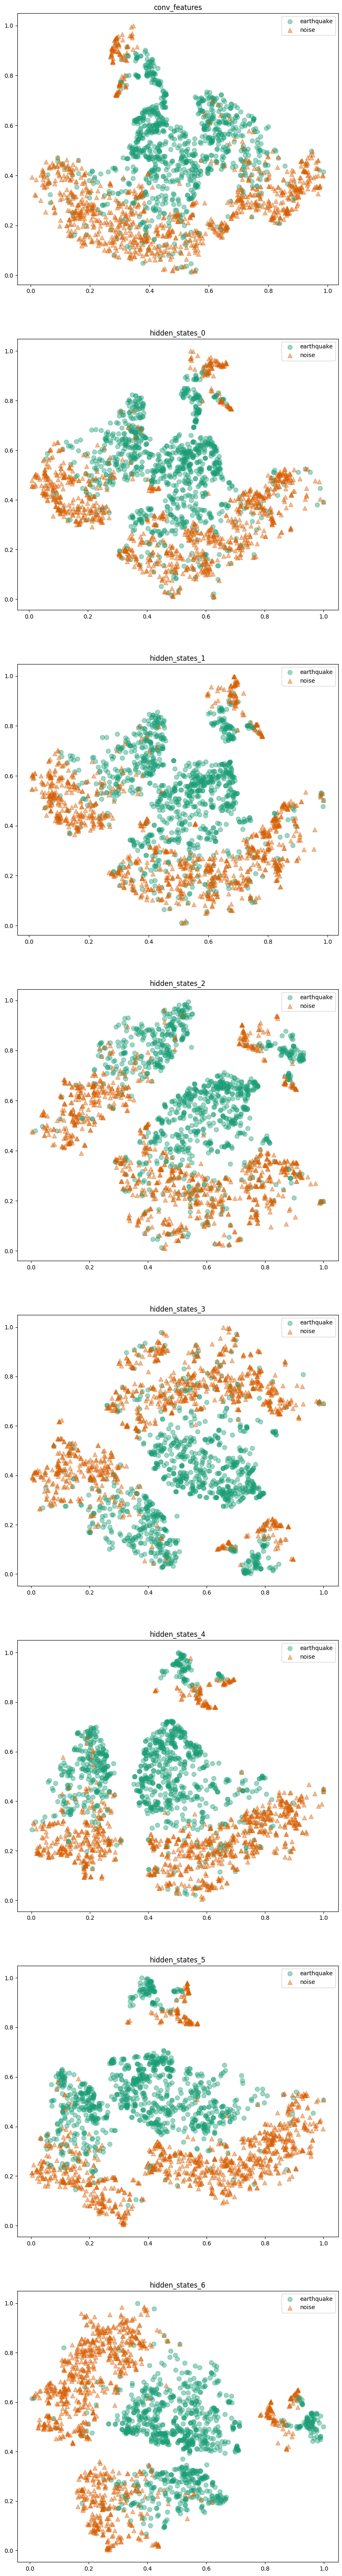

In [30]:
num_points_to_show_per_label = 1000

_, axes = plt.subplots(len(tsne_embedding_dict), 1, figsize=(10, 10 * len(tsne_embedding_dict)))

for j, (key, embeddings) in enumerate(tsne_embedding_dict.items()):
  embeddings = MinMaxScaler().fit_transform(embeddings)

  for k, label in enumerate(np.unique(y).tolist()):
    axes[j].scatter(
      *embeddings[ np.array(label) == y][:num_points_to_show_per_label].T,
      label=label,
      marker=markers[label],
      s=60,
      color=plt.cm.Dark2(k),
      alpha=0.425,
      zorder=2,
    )
  axes[j].legend()
  axes[j].set_title(key)